In [ ]:
#random forest
#4-28-25

#grouping response quality variable by month, year

In [42]:
#import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
from itertools import product

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor 


In [218]:
#import csv
lance_data = pd.read_csv('/project/90daydata/nematode_ml/Lance/one_hot_encode_practice_4-25-25.csv')

In [219]:
#display some values with a nice visual format
display(lance_data.head())

,sample_id,year,month,treatment,location,rep,turf_quality,ndvi,lance,RKN,sting
0,1,2019,march,indemnify,north,1,0.98,0.65,589,589,589
1,2,2019,march,none,north,1,0.95,0.67,332,332,332
2,3,2019,march,indemnify,north,2,0.90,0.88,1005,1005,1005
3,4,2019,march,none,north,2,0.88,0.45,754,754,754
4,5,2019,june,indemnify,north,1,0.98,0.65,589,589,589


In [4]:
display(lance_data)

,sample_id,year,month,treatment,location,rep,turf_quality,ndvi,lance,RKN,sting
0,1,2019,march,indemnify,north,1,0.98,0.65,589,589,589
1,2,2019,march,none,north,2,0.95,0.67,332,332,332
2,3,2019,march,indemnify,north,1,0.90,0.88,1005,1005,1005
3,4,2019,march,none,north,2,0.88,0.45,754,754,754
4,5,2019,june,indemnify,north,1,0.98,0.65,589,589,589
...,...,...,...,...,...,...,...,...,...,...,...
59,60,2020,september,none,south,2,0.88,0.45,754,754,754
60,61,2020,december,indemnify,south,1,0.98,0.65,589,589,589
61,62,2020,december,none,south,2,0.95,0.67,332,332,332
62,63,2020,december,indemnify,south,1,0.90,0.88,1005,1005,1005


In [220]:
#print levels of variables of interest
var_interest = ['turf_quality']
print(var_interest)

years = lance_data['year'].unique().astype(str)
print(years)

months = lance_data['month'].unique().astype(str)
print(months)


['turf_quality']
['2019' '2020']
['march' 'june' 'september' 'december']


In [221]:
#list of remaining predictor variables not to be included in combined columns
#this list will be used to add variables to dataframe that contains new combined variables
#select variables that will not be combined with other variables (select location, treatment...etc)
fix_var = ['location', 'treatment', 'rep']

In [222]:
#USE THIS
#get a dataframe with all the unique value combinations (of non-combined variables)
#this is performed without specifying sppecific variables in the code
#Bing "how to extract unique values from all columns python and obtain unique combinations using product cartesian"

names = pd.DataFrame()

for i in fix_var:
    ss = lance_data[i].unique()
    ss = pd.DataFrame(ss, columns=[i])
    names = pd.concat([names.reset_index(drop=True), ss.reset_index(drop=True)], axis=1)


####################
# Sample DataFrame
df = pd.DataFrame(names)

# Extract unique values from all columns
unique_values = {col: df[col].unique() for col in df.columns}

# Get the Cartesian product (all unique combinations) of unique values
cartesian_product = list(product(*unique_values.values()))

# Convert the Cartesian product to a DataFrame
cartesian_df = pd.DataFrame(cartesian_product, columns=df.columns)

#get column name order
idx_col_order = list(cartesian_df.columns)

# make index from column values
cartesian_df['idx'] = cartesian_df.apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

print(cartesian_df)





  location  treatment  rep                idx
0    north  indemnify    1  north_indemnify_1
1    north  indemnify    2  north_indemnify_2
2    north       none    1       north_none_1
3    north       none    2       north_none_2
4    south  indemnify    1  south_indemnify_1
5    south  indemnify    2  south_indemnify_2
6    south       none    1       south_none_1
7    south       none    2       south_none_2


In [223]:
print(cartesian_df.location.value_counts(),"\n")
print(cartesian_df.treatment.value_counts())
print(cartesian_df.rep.value_counts())
print(cartesian_df.idx.value_counts())

north    4
south    4
Name: location, dtype: int64 

indemnify    4
none         4
Name: treatment, dtype: int64
1    4
2    4
Name: rep, dtype: int64
north_indemnify_1    1
north_indemnify_2    1
north_none_1         1
north_none_2         1
south_indemnify_1    1
south_indemnify_2    1
south_none_1         1
south_none_2         1
Name: idx, dtype: int64


In [224]:
print(idx_col_order)

['location', 'treatment', 'rep']


In [225]:
#create list of variables of interest to investigate further
#these should be different that the 'fix_var' variables
var_interest = ['turf_quality', 'ndvi', 'lance', 'RKN', 'sting']
print(var_interest)

['turf_quality', 'ndvi', 'lance', 'RKN', 'sting']


In [182]:
#OLD
#create new combined variables
#save columns with variables to be compared
#options could include reponse variable of intererst + year + month
#idea is to be able to ask, "what sampling date most affects turf quality at date X"

new_df = pd.DataFrame(cartesian_df)

for v in var_interest:
    for i in years:
        for m in months:
            NewColumn = i + '_' + m
            #subset by month and year. hard coding. can modify this line to include different variables
            subset_df = lance_data[(lance_data['year'].astype(int)  == i.astype(int) ) & (lance_data['month'] == m)]
            subset_df = pd.DataFrame(subset_df)
            #create a subset based on the index order in cartesian dataframe 
            idx_subset = subset_df[idx_col_order]
            #create index values for the subset to line up with cartisian df
            subset_idx = idx_subset.apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
            subset_df['idx'] = subset_idx
            #print(subset_idx)
            #use index locations for the variables of interest
            subset_df = subset_df.rename(columns={var_interest[0]: var_interest[0] + '_' + NewColumn})
            subset_df = subset_df.rename(columns={var_interest[1]: var_interest[1] + '_' + NewColumn})
            subset_df = subset_df.rename(columns={var_interest[2]: var_interest[2] + '_' + NewColumn})
            subset_df = subset_df.rename(columns={var_interest[3]: var_interest[3] + '_' + NewColumn})
            subset_df = subset_df.rename(columns={var_interest[4]: var_interest[4] + '_' + NewColumn})

            #print(subset_df)
            
            #print(new_df)
            
            #hard coded subset indicies
            #treatment, location, rep, turf_quality_, ndvi_, lance_, RKN_, sting_, idx
            columns_new = subset_df.iloc[:,[3, 4, 5, 6, 7, 8, 9, 10, 11]]
            
            
            #print(columns_new)
            
            #reseting index to allow for merging by index
            #CONFIRM THAT THESE INDICIES LINE UP CORRECTLY
            #columns_new = columns_new.reset_index(drop=True) 
            #print(columns_new)
            
            #collecting the new column names to be included in the new_df
            columns_to_merge = columns_new.columns.difference(new_df.columns)
            #print(list(columns_to_merge))
            #print(columns_new)
            #print(new_df)
            #merging the new_df and columns_ac to include all the new_df and only the columns not shared in columns_ac
            #returns a data frame with all the unique combinations of fix_var and the new variables
            
            
            #new_df = pd.merge(new_df, columns_ac[columns_to_merge], left_index=True, right_index=True)

            ###################################
            #this code includes the fix_var column in new dataframe when indexing
            #print(columns_new)
            #merged_df = pd.merge(columns_new, cartesian_df, on=list(cartesian_df.columns))    

            #concat aligns based on index so reseting index allows for combining in the same rows        
            #columns_new = subset_df.iloc[:,[6, 7, 8, 9, 10]]   
            #new_df = pd.concat([new_df.reset_index(drop=True), columns_new.reset_index(drop=True)], axis=1)

            #prints the index column that is not included in cuurent code
            #print(new_df.idx.value_counts())
            
 
   

IndexError: list index out of range

In [226]:
#check wich column to start renaming
#remember starts with 0
print(lance_data.columns)

Index(['sample_id', 'year', 'month', 'treatment', 'location', 'rep',
       'turf_quality', 'ndvi', 'lance', 'RKN', 'sting'],
      dtype='object')


In [ ]:
#WORK ON CODE BELOW

In [232]:
#USE THIS

#Bing
#how do i efficiently create seperate subsets of a dataframe based on the treatment and sample time combinations python

#nth column to select after to rename
#set depending on data structure
column_start = 6
#removing sample_id, year, and month from second subset
omit_columns = 3

new_df = pd.DataFrame(cartesian_df)

# Group by 'Treatment' and 'SampleTime'
grouped = lance_data.groupby(['year', 'month'])

# Create a dictionary to store subsets
subsets = {name: group for name, group in grouped}


#the key is the (year, month) tuple and the value is the subset dataframe
for key, value in subsets.items():
    subset_df = pd.DataFrame(value)
    #print(subset_df)
    # Columns to add suffix to
    columns_to_suffix = subset_df.iloc[:, column_start:]
    suffix = "_" + '_'.join(map(str, key))
    
    # Adding suffix to selected columns
    idx_subset = subset_df[idx_col_order]
    subset_df.rename(columns={col: col + suffix for col in columns_to_suffix}, inplace=True)
    subset_idx = idx_subset.apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    subset_df['idx'] = subset_idx
    #print(subset_df)
    # Access a specific subset
    #subset_2019_march = subsets[(2019, 'march')]
    #print(subset_2019_march)

    #subset indicies
    #treatment, location, rep, turf_quality_, ndvi_, lance_, RKN_, sting_, idx
    #omit sample_id, year, month
    columns_new = pd.DataFrame(subset_df.iloc[:,omit_columns:])
    #display(columns_new)
    #display(cartesian_df)
    #columns_to_merge = columns_new.columns.difference(new_df.columns)

    #print(list(columns_to_merge),"\n")
   
    #merging the new_df and columns_ac to include all the new_df and only the columns not shared in columns_ac
    #returns a data frame with all the unique combinations of fix_var and the new variables
    #new_df = pd.merge(new_df, columns_new[['idx'] + list(columns_to_merge)], on='idx', how='left')
    #merged_df = pd.merge(new_df, columns_new[['idx'] + list(columns_to_merge)], on='idx', how='left')


# Identify unique columns in df2
    unique_columns_df2 = [col for col in columns_new.columns if col not in new_df.columns or col == 'idx']
    #unique_columns_df2 = [col for col in columns_new.columns if col not in cartesian_df.columns]
    #print(unique_columns_df2)
    #display(columns_new[unique_columns_df2])
    #new_df = pd.merge(new_df, columns_new[unique_columns_df2], on='idx')


    #new_df = pd.concat([new_df.set_index('idx'), unique_columns_df2.set_index('idx')], axis=1).reset_index()
    #print(new_df)

    
# Merge DataFrames
    new_df = pd.merge(new_df, columns_new[unique_columns_df2], on='idx', how='left')

    #columns_to_merge =[col for col in columns_new.columns if col not in new_df.columns or col == 'idx']
    #print(columns_to_merge)    
#new_df = pd.merge(new_df, columns_new[columns_to_merge], on = 'idx', how = 'left')
    
#new_df = new_df.join(columns_new[[col for col in columns_new.columns if col not in new_df.columns]], how='left')
    
    #display(new_df)







In [233]:
#should give one row for each unique location, treatment, rep combination (see idx)
display(new_df)

,location,treatment,rep,idx,turf_quality_2019_december,ndvi_2019_december,lance_2019_december,RKN_2019_december,sting_2019_december,turf_quality_2019_june,...,turf_quality_2020_march,ndvi_2020_march,lance_2020_march,RKN_2020_march,sting_2020_march,turf_quality_2020_september,ndvi_2020_september,lance_2020_september,RKN_2020_september,sting_2020_september
0,north,indemnify,1,north_indemnify_1,0.98,0.65,589,589,589,0.98,...,0.98,0.65,589,589,589,0.98,0.65,589,589,589
1,north,indemnify,2,north_indemnify_2,0.90,0.88,1005,1005,1005,0.90,...,0.90,0.88,1005,1005,1005,0.90,0.88,1005,1005,1005
2,north,none,1,north_none_1,0.95,0.67,332,332,332,0.95,...,0.95,0.67,332,332,332,0.95,0.67,332,332,332
3,north,none,2,north_none_2,0.88,0.45,754,754,754,0.88,...,0.88,0.45,754,754,754,0.88,0.45,754,754,754
4,south,indemnify,1,south_indemnify_1,0.98,0.65,589,589,589,0.98,...,0.98,0.65,589,589,589,0.98,0.65,589,589,589
5,south,indemnify,2,south_indemnify_2,0.90,0.88,1005,1005,1005,0.90,...,0.90,0.88,1005,1005,1005,0.90,0.88,1005,1005,1005
6,south,none,1,south_none_1,0.95,0.67,332,332,332,0.95,...,0.95,0.67,332,332,332,0.95,0.67,332,332,332
7,south,none,2,south_none_2,0.88,0.45,754,754,754,0.88,...,0.88,0.45,754,754,754,0.88,0.45,754,754,754


In [40]:
#SAVE
#Bing
#how do i efficiently create seperate subsets of a dataframe based on the treatment and sample time combinations python

#nth column to select after to rename
#set depending on data structure
column_start = 6

# Group by 'Treatment' and 'SampleTime'
grouped = lance_data.groupby(['year', 'month'])

# Create a dictionary to store subsets
subsets = {name: group for name, group in grouped}

#the key is the (year, month) tuple and the value is the subset dataframe
for key, value in subsets.items():
    df = pd.DataFrame(value)
    # Columns to add suffix to
    columns_to_suffix = df.iloc[:, column_start:]
    suffix = "_" + '_'.join(map(str, key))
    
    # Adding suffix to selected columns
    df.rename(columns={col: col + suffix for col in columns_to_suffix}, inplace=True)
    display(df)
    #subsets[key] = subsets.rename(columns={var_interest[6]: key + '_' + value + '_' + NewColumn})


# Access a specific subset
#subset_2019_march = subsets[(2019, 'march')]
#print(subset_2019_march)



,sample_id,year,month,treatment,location,rep,turf_quality_2019_december,ndvi_2019_december,lance_2019_december,RKN_2019_december,sting_2019_december
12,13,2019,december,indemnify,north,1,0.98,0.65,589,589,589
13,14,2019,december,none,north,2,0.95,0.67,332,332,332
14,15,2019,december,indemnify,north,1,0.90,0.88,1005,1005,1005
15,16,2019,december,none,north,2,0.88,0.45,754,754,754
44,45,2019,december,indemnify,south,1,0.98,0.65,589,589,589
45,46,2019,december,none,south,2,0.95,0.67,332,332,332
46,47,2019,december,indemnify,south,1,0.90,0.88,1005,1005,1005
47,48,2019,december,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep,turf_quality_2019_june,ndvi_2019_june,lance_2019_june,RKN_2019_june,sting_2019_june
4,5,2019,june,indemnify,north,1,0.98,0.65,589,589,589
5,6,2019,june,none,north,2,0.95,0.67,332,332,332
6,7,2019,june,indemnify,north,1,0.90,0.88,1005,1005,1005
7,8,2019,june,none,north,2,0.88,0.45,754,754,754
36,37,2019,june,indemnify,south,1,0.98,0.65,589,589,589
37,38,2019,june,none,south,2,0.95,0.67,332,332,332
38,39,2019,june,indemnify,south,1,0.90,0.88,1005,1005,1005
39,40,2019,june,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep,turf_quality_2019_march,ndvi_2019_march,lance_2019_march,RKN_2019_march,sting_2019_march
0,1,2019,march,indemnify,north,1,0.98,0.65,589,589,589
1,2,2019,march,none,north,2,0.95,0.67,332,332,332
2,3,2019,march,indemnify,north,1,0.90,0.88,1005,1005,1005
3,4,2019,march,none,north,2,0.88,0.45,754,754,754
32,33,2019,march,indemnify,south,1,0.98,0.65,589,589,589
33,34,2019,march,none,south,2,0.95,0.67,332,332,332
34,35,2019,march,indemnify,south,1,0.90,0.88,1005,1005,1005
35,36,2019,march,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep,turf_quality_2019_september,ndvi_2019_september,lance_2019_september,RKN_2019_september,sting_2019_september
8,9,2019,september,indemnify,north,1,0.98,0.65,589,589,589
9,10,2019,september,none,north,2,0.95,0.67,332,332,332
10,11,2019,september,indemnify,north,1,0.90,0.88,1005,1005,1005
11,12,2019,september,none,north,2,0.88,0.45,754,754,754
40,41,2019,september,indemnify,south,1,0.98,0.65,589,589,589
41,42,2019,september,none,south,2,0.95,0.67,332,332,332
42,43,2019,september,indemnify,south,1,0.90,0.88,1005,1005,1005
43,44,2019,september,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep,turf_quality_2020_december,ndvi_2020_december,lance_2020_december,RKN_2020_december,sting_2020_december
28,29,2020,december,indemnify,north,1,0.98,0.65,589,589,589
29,30,2020,december,none,north,2,0.95,0.67,332,332,332
30,31,2020,december,indemnify,north,1,0.90,0.88,1005,1005,1005
31,32,2020,december,none,north,2,0.88,0.45,754,754,754
60,61,2020,december,indemnify,south,1,0.98,0.65,589,589,589
61,62,2020,december,none,south,2,0.95,0.67,332,332,332
62,63,2020,december,indemnify,south,1,0.90,0.88,1005,1005,1005
63,64,2020,december,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep,turf_quality_2020_june,ndvi_2020_june,lance_2020_june,RKN_2020_june,sting_2020_june
20,21,2020,june,indemnify,north,1,0.98,0.65,589,589,589
21,22,2020,june,none,north,2,0.95,0.67,332,332,332
22,23,2020,june,indemnify,north,1,0.90,0.88,1005,1005,1005
23,24,2020,june,none,north,2,0.88,0.45,754,754,754
52,53,2020,june,indemnify,south,1,0.98,0.65,589,589,589
53,54,2020,june,none,south,2,0.95,0.67,332,332,332
54,55,2020,june,indemnify,south,1,0.90,0.88,1005,1005,1005
55,56,2020,june,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep,turf_quality_2020_march,ndvi_2020_march,lance_2020_march,RKN_2020_march,sting_2020_march
16,17,2020,march,indemnify,north,1,0.98,0.65,589,589,589
17,18,2020,march,none,north,2,0.95,0.67,332,332,332
18,19,2020,march,indemnify,north,1,0.90,0.88,1005,1005,1005
19,20,2020,march,none,north,2,0.88,0.45,754,754,754
48,49,2020,march,indemnify,south,1,0.98,0.65,589,589,589
49,50,2020,march,none,south,2,0.95,0.67,332,332,332
50,51,2020,march,indemnify,south,1,0.90,0.88,1005,1005,1005
51,52,2020,march,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep,turf_quality_2020_september,ndvi_2020_september,lance_2020_september,RKN_2020_september,sting_2020_september
24,25,2020,september,indemnify,north,1,0.98,0.65,589,589,589
25,26,2020,september,none,north,2,0.95,0.67,332,332,332
26,27,2020,september,indemnify,north,1,0.90,0.88,1005,1005,1005
27,28,2020,september,none,north,2,0.88,0.45,754,754,754
56,57,2020,september,indemnify,south,1,0.98,0.65,589,589,589
57,58,2020,september,none,south,2,0.95,0.67,332,332,332
58,59,2020,september,indemnify,south,1,0.90,0.88,1005,1005,1005
59,60,2020,september,none,south,2,0.88,0.45,754,754,754


In [47]:
#Bing
#how do i efficiently create seperate subsets of a dataframe based on the treatment and sample time combinations python

#nth column to select after to rename
#set depending on data structure
column_start = 5

# Group by 'Treatment' and 'SampleTime'
grouped = lance_data.groupby(['year', 'month'])

# Create a dictionary to store subsets
subsets = {name: group for name, group in grouped}

#the key is the (year, month) tuple and the value is the subset dataframe
for key, value in subsets.items():
    df = pd.DataFrame(value)
    # Columns to add suffix to
    columns_to_suffix = df.iloc[:, column_start:]
    suffix = '_new'
    # Adding suffix to selected columns
    df.rename(columns={col: col + suffix for col in columns_to_suffix}, inplace=True)
    display(df)
    #subsets[key] = subsets.rename(columns={var_interest[6]: key + '_' + value + '_' + NewColumn})


# Access a specific subset
subset_A1 = subsets[(2019, 'march')]
#print(subset_A1)

subset_B1 = subsets[(2020, 'december')]
#print(subset_B1)



,sample_id,year,month,treatment,location,rep_new,turf_quality_new,ndvi_new,lance_new,RKN_new,sting_new
12,13,2019,december,indemnify,north,1,0.98,0.65,589,589,589
13,14,2019,december,none,north,2,0.95,0.67,332,332,332
14,15,2019,december,indemnify,north,1,0.90,0.88,1005,1005,1005
15,16,2019,december,none,north,2,0.88,0.45,754,754,754
44,45,2019,december,indemnify,south,1,0.98,0.65,589,589,589
45,46,2019,december,none,south,2,0.95,0.67,332,332,332
46,47,2019,december,indemnify,south,1,0.90,0.88,1005,1005,1005
47,48,2019,december,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep_new,turf_quality_new,ndvi_new,lance_new,RKN_new,sting_new
4,5,2019,june,indemnify,north,1,0.98,0.65,589,589,589
5,6,2019,june,none,north,2,0.95,0.67,332,332,332
6,7,2019,june,indemnify,north,1,0.90,0.88,1005,1005,1005
7,8,2019,june,none,north,2,0.88,0.45,754,754,754
36,37,2019,june,indemnify,south,1,0.98,0.65,589,589,589
37,38,2019,june,none,south,2,0.95,0.67,332,332,332
38,39,2019,june,indemnify,south,1,0.90,0.88,1005,1005,1005
39,40,2019,june,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep_new,turf_quality_new,ndvi_new,lance_new,RKN_new,sting_new
0,1,2019,march,indemnify,north,1,0.98,0.65,589,589,589
1,2,2019,march,none,north,2,0.95,0.67,332,332,332
2,3,2019,march,indemnify,north,1,0.90,0.88,1005,1005,1005
3,4,2019,march,none,north,2,0.88,0.45,754,754,754
32,33,2019,march,indemnify,south,1,0.98,0.65,589,589,589
33,34,2019,march,none,south,2,0.95,0.67,332,332,332
34,35,2019,march,indemnify,south,1,0.90,0.88,1005,1005,1005
35,36,2019,march,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep_new,turf_quality_new,ndvi_new,lance_new,RKN_new,sting_new
8,9,2019,september,indemnify,north,1,0.98,0.65,589,589,589
9,10,2019,september,none,north,2,0.95,0.67,332,332,332
10,11,2019,september,indemnify,north,1,0.90,0.88,1005,1005,1005
11,12,2019,september,none,north,2,0.88,0.45,754,754,754
40,41,2019,september,indemnify,south,1,0.98,0.65,589,589,589
41,42,2019,september,none,south,2,0.95,0.67,332,332,332
42,43,2019,september,indemnify,south,1,0.90,0.88,1005,1005,1005
43,44,2019,september,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep_new,turf_quality_new,ndvi_new,lance_new,RKN_new,sting_new
28,29,2020,december,indemnify,north,1,0.98,0.65,589,589,589
29,30,2020,december,none,north,2,0.95,0.67,332,332,332
30,31,2020,december,indemnify,north,1,0.90,0.88,1005,1005,1005
31,32,2020,december,none,north,2,0.88,0.45,754,754,754
60,61,2020,december,indemnify,south,1,0.98,0.65,589,589,589
61,62,2020,december,none,south,2,0.95,0.67,332,332,332
62,63,2020,december,indemnify,south,1,0.90,0.88,1005,1005,1005
63,64,2020,december,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep_new,turf_quality_new,ndvi_new,lance_new,RKN_new,sting_new
20,21,2020,june,indemnify,north,1,0.98,0.65,589,589,589
21,22,2020,june,none,north,2,0.95,0.67,332,332,332
22,23,2020,june,indemnify,north,1,0.90,0.88,1005,1005,1005
23,24,2020,june,none,north,2,0.88,0.45,754,754,754
52,53,2020,june,indemnify,south,1,0.98,0.65,589,589,589
53,54,2020,june,none,south,2,0.95,0.67,332,332,332
54,55,2020,june,indemnify,south,1,0.90,0.88,1005,1005,1005
55,56,2020,june,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep_new,turf_quality_new,ndvi_new,lance_new,RKN_new,sting_new
16,17,2020,march,indemnify,north,1,0.98,0.65,589,589,589
17,18,2020,march,none,north,2,0.95,0.67,332,332,332
18,19,2020,march,indemnify,north,1,0.90,0.88,1005,1005,1005
19,20,2020,march,none,north,2,0.88,0.45,754,754,754
48,49,2020,march,indemnify,south,1,0.98,0.65,589,589,589
49,50,2020,march,none,south,2,0.95,0.67,332,332,332
50,51,2020,march,indemnify,south,1,0.90,0.88,1005,1005,1005
51,52,2020,march,none,south,2,0.88,0.45,754,754,754


,sample_id,year,month,treatment,location,rep_new,turf_quality_new,ndvi_new,lance_new,RKN_new,sting_new
24,25,2020,september,indemnify,north,1,0.98,0.65,589,589,589
25,26,2020,september,none,north,2,0.95,0.67,332,332,332
26,27,2020,september,indemnify,north,1,0.90,0.88,1005,1005,1005
27,28,2020,september,none,north,2,0.88,0.45,754,754,754
56,57,2020,september,indemnify,south,1,0.98,0.65,589,589,589
57,58,2020,september,none,south,2,0.95,0.67,332,332,332
58,59,2020,september,indemnify,south,1,0.90,0.88,1005,1005,1005
59,60,2020,september,none,south,2,0.88,0.45,754,754,754


In [13]:
#create list of variables of interest to investigate further
#these should be different that the 'fix_var' variables
var_interest = ['turf_quality', 'ndvi', 'lance', 'RKN', 'sting']
years = lance_data['year'].unique().astype(str)
months = lance_data['month'].unique().astype(str)

print(var_interest)
print(years)
print(months)

['turf_quality', 'ndvi', 'lance', 'RKN', 'sting']
['2019' '2020']
['march' 'june' 'september' 'december']


In [27]:
#create list of variables of interest to investigate further
#these should be different that the 'fix_var' variables
var_interest = ['turf_quality', 'ndvi', 'lance', 'RKN', 'sting']
years = lance_data['year'].unique()
months = lance_data['month'].unique()

print(var_interest)
print(years)
print(months)

['turf_quality', 'ndvi', 'lance', 'RKN', 'sting']
[2019 2020]
['march' 'june' 'september' 'december']


In [76]:
subsets =[(year, month, lance_data[(lance_data['year'] == year) & (lance_data['month'] == month)]) for year in years for month in months]
# Display the subsets
for year, treatment, subset in subsets:
    #print(f"Year: {year}, month: {month}")
    print(subset[:8])
    print()

    sample_id  year  month  treatment location  rep  turf_quality  ndvi  \
0           1  2019  march  indemnify    north    1          0.98  0.65   
1           2  2019  march       none    north    2          0.95  0.67   
2           3  2019  march  indemnify    north    1          0.90  0.88   
3           4  2019  march       none    north    2          0.88  0.45   
32         33  2019  march  indemnify    south    1          0.98  0.65   
33         34  2019  march       none    south    2          0.95  0.67   
34         35  2019  march  indemnify    south    1          0.90  0.88   
35         36  2019  march       none    south    2          0.88  0.45   

    lance   RKN  sting  
0     589   589    589  
1     332   332    332  
2    1005  1005   1005  
3     754   754    754  
32    589   589    589  
33    332   332    332  
34   1005  1005   1005  
35    754   754    754  

    sample_id  year month  treatment location  rep  turf_quality  ndvi  lance  \
4           5  20

In [77]:
print(subset[:8])

    sample_id  year     month  treatment location  rep  turf_quality  ndvi  \
28         29  2020  december  indemnify    north    1          0.98  0.65   
29         30  2020  december       none    north    2          0.95  0.67   
30         31  2020  december  indemnify    north    1          0.90  0.88   
31         32  2020  december       none    north    2          0.88  0.45   
60         61  2020  december  indemnify    south    1          0.98  0.65   
61         62  2020  december       none    south    2          0.95  0.67   
62         63  2020  december  indemnify    south    1          0.90  0.88   
63         64  2020  december       none    south    2          0.88  0.45   

    lance   RKN  sting  
28    589   589    589  
29    332   332    332  
30   1005  1005   1005  
31    754   754    754  
60    589   589    589  
61    332   332    332  
62   1005  1005   1005  
63    754   754    754  


In [86]:
print(subset[:8])

    sample_id  year     month  treatment location  rep  turf_quality  ndvi  \
28         29  2020  december  indemnify    north    1          0.98  0.65   
29         30  2020  december       none    north    2          0.95  0.67   
30         31  2020  december  indemnify    north    1          0.90  0.88   
31         32  2020  december       none    north    2          0.88  0.45   
60         61  2020  december  indemnify    south    1          0.98  0.65   
61         62  2020  december       none    south    2          0.95  0.67   
62         63  2020  december  indemnify    south    1          0.90  0.88   
63         64  2020  december       none    south    2          0.88  0.45   

    lance   RKN  sting  
28    589   589    589  
29    332   332    332  
30   1005  1005   1005  
31    754   754    754  
60    589   589    589  
61    332   332    332  
62   1005  1005   1005  
63    754   754    754  


In [66]:
for year, month, subset in subsets:
    print(f"Year: {year}, Treatment: {treatment}")

Year: 2019, Treatment: december
Year: 2019, Treatment: december
Year: 2019, Treatment: december
Year: 2019, Treatment: december
Year: 2020, Treatment: december
Year: 2020, Treatment: december
Year: 2020, Treatment: december
Year: 2020, Treatment: december


In [36]:
#USE THIS ONE
#create new combined variables
#save columns with variables to be compared
#options could include reponse variable of intererst + year + month
#idea is to be able to ask, "what sampling date most affects turf quality at date X"

new_df = pd.DataFrame(cartesian_df)


subsets =[(year, month, lance_data[(lance_data['year'] == year) & (lance_data['month'] == month)]) for year in years for month in months]
# Display the subsets
for year, treatment, subset in subsets:
    #create a subset based on the index order in cartesian dataframe 
            
            #use index locations for the variables of interest
            subset_df = subset.rename(columns={subset[6]: subset[1] + '_' + subset[2] + '_' + subset[6]})
            subset_df = subset.rename(columns={subset[7]: subset[1] + '_' + subset[2] + '_' + subset[7]})
            subset_df = subset.rename(columns={subset[8]: subset[1] + '_' + subset[2] + '_' + subset[8]})
            subset_df = subset.rename(columns={subset[9]: subset[1] + '_' + subset[2] + '_' + subset[9]})
            subset_df = subset.rename(columns={subset[10]: subset[1] + '_' + subset[2] + '_' + subset[10]})
            #subset_df = subset.rename(columns={subset[6]: subset[11] + '_' + subset[2] + '_' + subset[11]})
    

            idx_subset = subset_df[idx_col_order]
            #create index values for the subset to line up with cartisian df
            subset_idx = idx_subset.apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
            subset_df['idx'] = subset_idx
            #print(subset_idx)
    
            #hard coded subset indicies
            #treatment, location, rep, turf_quality_, ndvi_, lance_, RKN_, sting_, idx
            columns_new = subset_df.iloc[:,[3, 4, 5, 6, 7, 8, 9, 10, 11]]
            
            columns_to_merge = columns_new.columns.difference(new_df.columns)
                       
            new_df = pd.merge(new_df, columns_new[['idx'] + list (columns_to_merge)], on='idx', how='left')

           
 
   

KeyError: 6

In [21]:
s = [lance_data[lance_data['year'].astype('str') == value] for value in years.astype('str')]
print(s)

[    sample_id  year      month  treatment location  rep  turf_quality  ndvi  \
0           1  2019      march  indemnify    north    1          0.98  0.65   
1           2  2019      march       none    north    2          0.95  0.67   
2           3  2019      march  indemnify    north    1          0.90  0.88   
3           4  2019      march       none    north    2          0.88  0.45   
4           5  2019       june  indemnify    north    1          0.98  0.65   
5           6  2019       june       none    north    2          0.95  0.67   
6           7  2019       june  indemnify    north    1          0.90  0.88   
7           8  2019       june       none    north    2          0.88  0.45   
8           9  2019  september  indemnify    north    1          0.98  0.65   
9          10  2019  september       none    north    2          0.95  0.67   
10         11  2019  september  indemnify    north    1          0.90  0.88   
11         12  2019  september       none    north 

In [17]:
s = [lance_data[lance_data['month'] == value] for value in months]
print(s)

[    sample_id  year  month  treatment location  rep  turf_quality  ndvi  \
0           1  2019  march  indemnify    north    1          0.98  0.65   
1           2  2019  march       none    north    2          0.95  0.67   
2           3  2019  march  indemnify    north    1          0.90  0.88   
3           4  2019  march       none    north    2          0.88  0.45   
16         17  2020  march  indemnify    north    1          0.98  0.65   
17         18  2020  march       none    north    2          0.95  0.67   
18         19  2020  march  indemnify    north    1          0.90  0.88   
19         20  2020  march       none    north    2          0.88  0.45   
32         33  2019  march  indemnify    south    1          0.98  0.65   
33         34  2019  march       none    south    2          0.95  0.67   
34         35  2019  march  indemnify    south    1          0.90  0.88   
35         36  2019  march       none    south    2          0.88  0.45   
48         49  2020  mar

In [ ]:
#USE THIS ONE
#create new combined variables
#save columns with variables to be compared
#options could include reponse variable of intererst + year + month
#idea is to be able to ask, "what sampling date most affects turf quality at date X"

new_df = pd.DataFrame(cartesian_df)

for v in var_interest:
    for i in years:
        for m in months:
            NewColumn = i + '_' + m
            #subset by month and year. hard coding. can modify this line to include different variables
            subset_df = lance_data[(lance_data['year'].astype(int)  == i.astype(int) ) & (lance_data['month'] == m)]
            subset_df = pd.DataFrame(subset_df)
            #create a subset based on the index order in cartesian dataframe 
            idx_subset = subset_df[idx_col_order]
            #create index values for the subset to line up with cartisian df
            subset_idx = idx_subset.apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
            subset_df['idx'] = subset_idx
            #print(subset_idx)
            #use index locations for the variables of interest
            subset_df = subset_df.rename(columns={var_interest[0]: var_interest[0] + '_' + NewColumn})
            subset_df = subset_df.rename(columns={var_interest[1]: var_interest[1] + '_' + NewColumn})
            subset_df = subset_df.rename(columns={var_interest[2]: var_interest[2] + '_' + NewColumn})
            subset_df = subset_df.rename(columns={var_interest[3]: var_interest[3] + '_' + NewColumn})
            subset_df = subset_df.rename(columns={var_interest[4]: var_interest[4] + '_' + NewColumn})

            #print(subset_df)
            
            #print(new_df)
            
            #hard coded subset indicies
            #treatment, location, rep, turf_quality_, ndvi_, lance_, RKN_, sting_, idx
            columns_new = subset_df.iloc[:,[3, 4, 5, 6, 7, 8, 9, 10, 11]]
            
            
            #print(columns_new)
            
            #reseting index to allow for merging by index
            #CONFIRM THAT THESE INDICIES LINE UP CORRECTLY
            #columns_new = columns_new.reset_index(drop=True) 
            #print(columns_new)
            
            #collecting the new column names to be included in the new_df
            columns_to_merge = columns_new.columns.difference(new_df.columns)
            #print(list(columns_to_merge))
            #print(columns_new)
            #print(new_df)
            #merging the new_df and columns_ac to include all the new_df and only the columns not shared in columns_ac
            #returns a data frame with all the unique combinations of fix_var and the new variables
            
            new_df = pd.merge(new_df, columns_new[['idx'] + list (columns_to_merge)], on='idx', how='left')
            #new_df = pd.merge(new_df, columns_ac[columns_to_merge], left_index=True, right_index=True)

            ###################################
            #this code includes the fix_var column in new dataframe when indexing
            #print(columns_new)
            #merged_df = pd.merge(columns_new, cartesian_df, on=list(cartesian_df.columns))    

            #concat aligns based on index so reseting index allows for combining in the same rows        
            #columns_new = subset_df.iloc[:,[6, 7, 8, 9, 10]]   
            #new_df = pd.concat([new_df.reset_index(drop=True), columns_new.reset_index(drop=True)], axis=1)

            #prints the index column that is not included in cuurent code
            #print(new_df.idx.value_counts())
            
 
   

In [ ]:
#this dataframe should have one set of fix_var columns (location, treatment...etc) and then all the new combined variable columns 
#does not include first 3 columns from subset
display(new_df)

In [18]:
#this should include new combined columns and fix_var to use as index to join
#display(columns_new)

In [19]:
#includes all subsetted columns
#display(subset_df)

In [21]:
display(new_df)

,turf_quality_2019_march,ndvi_2019_march,lance_2019_march,RKN_2019_march,sting_2019_march,turf_quality_2019_june,ndvi_2019_june,lance_2019_june,RKN_2019_june,sting_2019_june,...,turf_quality_2020_september,ndvi_2020_september,lance_2020_september,RKN_2020_september,sting_2020_september,turf_quality_2020_december,ndvi_2020_december,lance_2020_december,RKN_2020_december,sting_2020_december
0,0.98,0.65,589,589,589,0.98,0.65,589,589,589,...,0.98,0.65,589,589,589,0.98,0.65,589,589,589
1,0.95,0.67,332,332,332,0.95,0.67,332,332,332,...,0.95,0.67,332,332,332,0.95,0.67,332,332,332
2,0.90,0.88,1005,1005,1005,0.90,0.88,1005,1005,1005,...,0.90,0.88,1005,1005,1005,0.90,0.88,1005,1005,1005
3,0.88,0.45,754,754,754,0.88,0.45,754,754,754,...,0.88,0.45,754,754,754,0.88,0.45,754,754,754
4,0.98,0.65,589,589,589,0.98,0.65,589,589,589,...,0.98,0.65,589,589,589,0.98,0.65,589,589,589
5,0.95,0.67,332,332,332,0.95,0.67,332,332,332,...,0.95,0.67,332,332,332,0.95,0.67,332,332,332
6,0.90,0.88,1005,1005,1005,0.90,0.88,1005,1005,1005,...,0.90,0.88,1005,1005,1005,0.90,0.88,1005,1005,1005
7,0.88,0.45,754,754,754,0.88,0.45,754,754,754,...,0.88,0.45,754,754,754,0.88,0.45,754,754,754


In [65]:
#get column names
col_names = list(lance_data.columns)
print(col_names)

['sample_id', 'year', 'month', 'treatment', 'location', 'rep', 'turf_quality', 'ndvi', 'lance', 'RKN', 'sting']


In [66]:
#create index
idx_columns = ['year', 'month', 'treatment', 'location', 'rep']

for i in idx_columns:
    print(lance_data[i].unique().astype(str))




['2019' '2020']
['march' 'june' 'september' 'december']
['indemnify' 'none']
['north' 'south']
['1' '2']


In [67]:
#want to combine turf quality, year, and month into a single variable
#look at specific column variables

print(lance_data.year.value_counts(),"\n")
print(lance_data.month.value_counts())

2019    32
2020    32
Name: year, dtype: int64 

march        16
june         16
september    16
december     16
Name: month, dtype: int64


In [4]:
var_interest = ['turf_quality', 'ndvi', 'lance', 'RKN', 'sting']
print(var_interest)

years = lance_data['year'].unique().astype(str)
print(years)

months = lance_data['month'].unique().astype(str)
print(months)


['turf_quality', 'ndvi', 'lance', 'RKN', 'sting']
['2019' '2020']
['march' 'june' 'september' 'december']


In [62]:
df = lance_data.pivot_table(index=['year', 'month'], columns= 'turf_quality' )
#print(df)
#print(df.rename_axis(columns=None).reset_index())

In [51]:
ld = lance_data.to_dict('series')

In [52]:
display(ld)

{'sample_id': 0      1
 1      2
 2      3
 3      4
 4      5
       ..
 59    60
 60    61
 61    62
 62    63
 63    64
 Name: sample_id, Length: 64, dtype: int64,
 'year': 0     2019
 1     2019
 2     2019
 3     2019
 4     2019
       ... 
 59    2020
 60    2020
 61    2020
 62    2020
 63    2020
 Name: year, Length: 64, dtype: int64,
 'month': 0         march
 1         march
 2         march
 3         march
 4          june
         ...    
 59    september
 60     december
 61     december
 62     december
 63     december
 Name: month, Length: 64, dtype: object,
 'treatment': 0     indemnify
 1          none
 2     indemnify
 3          none
 4     indemnify
         ...    
 59         none
 60    indemnify
 61         none
 62    indemnify
 63         none
 Name: treatment, Length: 64, dtype: object,
 'location': 0     north
 1     north
 2     north
 3     north
 4     north
       ...  
 59    south
 60    south
 61    south
 62    south
 63    south
 Name: location, 

In [69]:
new_df = pd.DataFrame()
for v in var_interest:
    for i in years:
        for m in months:
            NewColumn = v + '_' + i + '_' + m
            subset_df = lance_data[(lance_data['year'].astype(int)  == i.astype(int) ) & (lance_data['month'] == m)]
            #print(subset_df)
            new_df = pd.concat([new_df, subset_df])
            new_df[NewColumn]= subset_df[v]
            
        

In [71]:
print(new_df.tail())

    sample_id  year     month  treatment location  rep  turf_quality  ndvi  \
31         32  2020  december       none    north    2          0.88  0.45   
60         61  2020  december  indemnify    south    1          0.98  0.65   
61         62  2020  december       none    south    2          0.95  0.67   
62         63  2020  december  indemnify    south    1          0.90  0.88   
63         64  2020  december       none    south    2          0.88  0.45   

    lance   RKN  ...  RKN_2020_september  RKN_2020_december  sting_2019_march  \
31    754   754  ...                 NaN                NaN               NaN   
60    589   589  ...                 NaN                NaN               NaN   
61    332   332  ...                 NaN                NaN               NaN   
62   1005  1005  ...                 NaN                NaN               NaN   
63    754   754  ...                 NaN                NaN               NaN   

    sting_2019_june  sting_2019_september  s

In [90]:
new_df = {}

for v in var_interest:
    for i in years:
        for m in months:
            NewColumn = v + '_' + i + '_' + m
            subset_df = lance_data.loc[(lance_data['year'].astype(int)  == i.astype(int) ) & (lance_data['month'] == m)]
            #new_df = subset_df
            new_df.loc[new_df.loc[subset_df]] = NewColumn
            
        

AttributeError: 'dict' object has no attribute 'loc'

In [76]:
display(new_df)

{'turf_quality_2019_march': 0     0.98
 1     0.95
 2     0.90
 3     0.88
 32    0.98
 33    0.95
 34    0.90
 35    0.88
 Name: turf_quality, dtype: float64,
 'turf_quality_2019_june': 4     0.98
 5     0.95
 6     0.90
 7     0.88
 36    0.98
 37    0.95
 38    0.90
 39    0.88
 Name: turf_quality, dtype: float64,
 'turf_quality_2019_september': 8     0.98
 9     0.95
 10    0.90
 11    0.88
 40    0.98
 41    0.95
 42    0.90
 43    0.88
 Name: turf_quality, dtype: float64,
 'turf_quality_2019_december': 12    0.98
 13    0.95
 14    0.90
 15    0.88
 44    0.98
 45    0.95
 46    0.90
 47    0.88
 Name: turf_quality, dtype: float64,
 'turf_quality_2020_march': 16    0.98
 17    0.95
 18    0.90
 19    0.88
 48    0.98
 49    0.95
 50    0.90
 51    0.88
 Name: turf_quality, dtype: float64,
 'turf_quality_2020_june': 20    0.98
 21    0.95
 22    0.90
 23    0.88
 52    0.98
 53    0.95
 54    0.90
 55    0.88
 Name: turf_quality, dtype: float64,
 'turf_quality_2020_september': 24 

In [75]:
display(lance_data)

,sample_id,year,month,treatment,location,rep,turf_quality,ndvi,lance,RKN,sting
0,1,2019,march,indemnify,north,1,0.98,0.65,589,589,589
1,2,2019,march,none,north,2,0.95,0.67,332,332,332
2,3,2019,march,indemnify,north,1,0.90,0.88,1005,1005,1005
3,4,2019,march,none,north,2,0.88,0.45,754,754,754
4,5,2019,june,indemnify,north,1,0.98,0.65,589,589,589
...,...,...,...,...,...,...,...,...,...,...,...
59,60,2020,september,none,south,2,0.88,0.45,754,754,754
60,61,2020,december,indemnify,south,1,0.98,0.65,589,589,589
61,62,2020,december,none,south,2,0.95,0.67,332,332,332
62,63,2020,december,indemnify,south,1,0.90,0.88,1005,1005,1005


In [13]:
#remove sample_id column
lance_data = lance_data.drop('sample_id', axis = 1)

In [14]:
#look at specific column variable
print(lance_data.month.value_counts())

march        16
june         16
september    16
december     16
Name: month, dtype: int64


In [102]:
#manually select the columns to one hot enocode
cols_encode = ['year', 'month', 'treatment', 'location']

In [103]:
#create transformer
#random forest do not need feature scaling

#name for transformation (OHE)
#transformer object (OneHotEncoder())
#columns (cols_encode is a list of column names to encode)
#remainder = 'passthrough' tells to skip columns that are not specified

ct = ColumnTransformer(
    [('OHE', OneHotEncoder(sparse_output=False),
      cols_encode)], remainder = 'passthrough'
)

In [104]:
#remove the response variable from the dataframe
data_features = lance_data.drop("turf_quality", axis=1)
data_features = lance_data.drop("rep", axis=1)

In [105]:
print(data_features.head())

   year  month  treatment location  turf_quality  ndvi  lance   RKN  sting
0  2019  march  indemnify    north          0.98  0.65    589   589    589
1  2019  march       none    north          0.95  0.67    332   332    332
2  2019  march  indemnify    north          0.90  0.88   1005  1005   1005
3  2019  march       none    north          0.88  0.45    754   754    754
4  2019   june  indemnify    north          0.98  0.65    589   589    589


In [106]:
#set predictor variables and response variable
X = data_features
y = lance_data.turf_quality

In [107]:
print(X)

    year      month  treatment location  turf_quality  ndvi  lance   RKN  \
0   2019      march  indemnify    north          0.98  0.65    589   589   
1   2019      march       none    north          0.95  0.67    332   332   
2   2019      march  indemnify    north          0.90  0.88   1005  1005   
3   2019      march       none    north          0.88  0.45    754   754   
4   2019       june  indemnify    north          0.98  0.65    589   589   
..   ...        ...        ...      ...           ...   ...    ...   ...   
59  2020  september       none    south          0.88  0.45    754   754   
60  2020   december  indemnify    south          0.98  0.65    589   589   
61  2020   december       none    south          0.95  0.67    332   332   
62  2020   december  indemnify    south          0.90  0.88   1005  1005   
63  2020   december       none    south          0.88  0.45    754   754   

    sting  
0     589  
1     332  
2    1005  
3     754  
4     589  
..    ...  
59 

In [108]:
#split data
#split before encoding to retain column names
#splitting the predictor variables (data_features) and the response variable (turf_quality)
#can add argument -->  test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 0)

In [109]:
#apply transformations
#second value is the number of features (remember we removed the response variable)
#

ct.fit(X_train)
X_train_trans = ct.transform(X_train)
print(X_train_trans.shape)
print(ct.fit(X_train))

(48, 15)
ColumnTransformer(remainder='passthrough',
                  transformers=[('OHE', OneHotEncoder(sparse_output=False),
                                 ['year', 'month', 'treatment', 'location'])])


In [110]:
#print new feature names
print(ct.get_feature_names_out())


['OHE__year_2019' 'OHE__year_2020' 'OHE__month_december' 'OHE__month_june'
 'OHE__month_march' 'OHE__month_september' 'OHE__treatment_indemnify'
 'OHE__treatment_none' 'OHE__location_north' 'OHE__location_south'
 'remainder__turf_quality' 'remainder__ndvi' 'remainder__lance'
 'remainder__RKN' 'remainder__sting']


In [22]:
#access the steps in the columntransformer
ct.named_transformers_.OHE

OneHotEncoder(sparse_output=False)

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [71]:


#for regressor, set max_features to = n_features pg. 90
#smaller max_feature values reduce overfitting pg. 90

forest = RandomForestRegressor(n_estimators = 12, random_state = 2)
forest.fit(X_train_trans, y_train)

RandomForestRegressor(n_estimators=12, random_state=2)

In [90]:
feat_labels = ct.get_feature_names_out()
importances = forest.feature_importances_
#sort features in descending order
indicies = np.argsort(importances)[::-1]

print(feat_labels)
print(importances)
print(indicies)

print(len(feat_labels))
print(len(importances))
print(len(indicies))

['OHE__year_2019' 'OHE__year_2020' 'OHE__month_december' 'OHE__month_june'
 'OHE__month_march' 'OHE__month_september' 'OHE__treatment_indemnify'
 'OHE__treatment_none' 'OHE__location_north' 'OHE__location_south'
 'OHE__rep_1' 'OHE__rep_2' 'remainder__ndvi' 'remainder__lance'
 'remainder__RKN' 'remainder__sting']
[0.13552459 0.06976948 0.05466776 0.10887371 0.10408697 0.03811077
 0.04767927 0.02946682 0.04794974 0.05296835 0.01890964 0.0338627
 0.02320416 0.10753812 0.04883335 0.07855459]
[ 0  3 13  4 15  1  2  9 14  8  6  5 11  7 12 10]
16
16
16


In [91]:
#print sorted list of features
for f in range(X_train_trans.shape[1]):
    print("%2d) %-*s %f" % (f+1,30, feat_labels[indicies[f]],
                            importances[indicies[f]]))

        

 1) OHE__year_2019                 0.135525
 2) OHE__month_june                0.108874
 3) remainder__lance               0.107538
 4) OHE__month_march               0.104087
 5) remainder__sting               0.078555
 6) OHE__year_2020                 0.069769
 7) OHE__month_december            0.054668
 8) OHE__location_south            0.052968
 9) remainder__RKN                 0.048833
10) OHE__location_north            0.047950
11) OHE__treatment_indemnify       0.047679
12) OHE__month_september           0.038111
13) OHE__rep_2                     0.033863
14) OHE__treatment_none            0.029467
15) remainder__ndvi                0.023204
16) OHE__rep_1                     0.018910


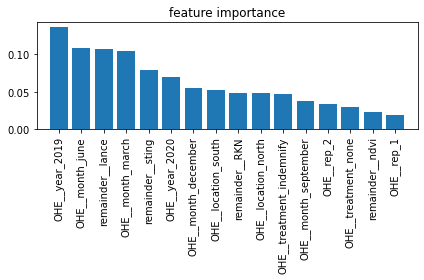

In [95]:
#plot feature importance
plt.title('feature importance')
plt.bar(range(X_train_trans.shape[1]),
           importances[indicies],
           align='center')
plt.xticks(range(X_train_trans.shape[1]),
           feat_labels[indicies], rotation = 90)
plt.xlim([-1,X_train_trans.shape[1]])
plt.tight_layout()
plt.show()